<a href="https://colab.research.google.com/github/FatmaBuseBorlu/Dramer-Dataset/blob/main/CNN1_Kodunun_Geli%C5%9Fmi%C5%9F_Modeli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.io as sio

In [ ]:
# DREAMER veri kümesini yükleme fonksiyonu
def load_dreamer_data(file_path):
    data = sio.loadmat(file_path)
    eeg_data = []
    labels = []
    for participant in range(23):
        for video in range(18):
            baseline = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['baseline'][0, 0][video, 0]
            stimuli = data['DREAMER'][0, 0]['Data'][0, participant]['EEG'][0, 0]['stimuli'][0, 0][video, 0]

            if stimuli.size == 0:
                continue

            if stimuli.shape[0] != 14:
                stimuli = stimuli.T

            eeg_data.append(stimuli)
            labels.append(data['DREAMER'][0, 0]['Data'][0, participant]['ScoreValence'][0, 0][video, 0])

    return eeg_data, np.array(labels)

In [ ]:
# EEG verilerini artırma fonksiyonu
def augment_eeg_data_with_labels(eeg_data, labels):
    augmented_data = []
    augmented_labels = []
    for i, sample in enumerate(eeg_data):
        noise = np.random.normal(0, 0.01, sample.shape)  # Gürültü ekleme
        shifted = np.roll(sample, shift=5, axis=1)       # Zaman kaydırma

        augmented_data.append(sample + noise)           # Gürültülü veri
        augmented_data.append(shifted)                  # Kaydırılmış veri

        # Aynı etiketi iki yeni örnek için ekliyoruz
        augmented_labels.append(labels[i])
        augmented_labels.append(labels[i])

    return np.concatenate([eeg_data, np.array(augmented_data)], axis=0), np.concatenate([labels, np.array(augmented_labels)])


In [ ]:
# EEG verilerini ön işleme
def preprocess_eeg_data(eeg_data):
    max_length = max(sample.shape[1] for sample in eeg_data)

    padded_eeg_data = []
    for sample in eeg_data:
        if sample.shape[1] < max_length:
            padding_shape = ((0, 0), (0, max_length - sample.shape[1]))
            padded_sample = np.pad(sample, padding_shape, mode='constant', constant_values=0)
        else:
            padded_sample = sample
        padded_eeg_data.append(padded_sample)

    eeg_data = np.array(padded_eeg_data)
    eeg_data = eeg_data[:, :, :, np.newaxis]  # CNN için (örnek, zaman, kanal, 1)
    scaler = StandardScaler()
    eeg_data = eeg_data.reshape(eeg_data.shape[0], -1)
    eeg_data = scaler.fit_transform(eeg_data)
    eeg_data = eeg_data.reshape(-1, eeg_data.shape[1] // 14, 14, 1)

    return eeg_data

In [ ]:
# Veri yükleme ve ön işleme
file_path = "/content/drive/MyDrive/Colab Notebooks/DREAMER.mat"
eeg_data, labels = load_dreamer_data(file_path)
eeg_data = preprocess_eeg_data(eeg_data)

In [ ]:
# Hedef etiketlerin binary hale getirilmesi
labels = LabelEncoder().fit_transform(labels > 5)  # 0 ve 1

In [ ]:
# Veri artırma işlemi
eeg_data, labels = augment_eeg_data_with_labels(eeg_data, labels)


In [ ]:
# Veri artırma sonrası boyut kontrolü
print("Veri artırma sonrası eeg_data boyutu:", eeg_data.shape)
print("Veri artırma sonrası labels boyutu:", labels.shape)

Veri artırma sonrası eeg_data boyutu: (1242, 50432, 14, 1)
Veri artırma sonrası labels boyutu: (1242,)


In [ ]:
# Eğitim ve test verisine ayırma
X_train, X_test, y_train, y_test = train_test_split(eeg_data, labels, test_size=0.2, random_state=42)

In [ ]:
# Eğitim ve doğrulama verilerinin kontrolü
print("Eğitim verisinin minimum ve maksimum değerleri:", X_train.min(), X_train.max())
print("Eğitim etiketleri:", np.unique(y_train))
print("Doğrulama etiketleri:", np.unique(y_test))

Eğitim verisinin minimum ve maksimum değerleri: -19.944354820278807 19.790265050459094
Eğitim etiketleri: [0]
Doğrulama etiketleri: [0]


In [ ]:
# Modeli tanımlama
model = Sequential([
    Conv2D(1, (3, 3), padding='same', kernel_regularizer=l2(1.0), input_shape=(eeg_data.shape[1], eeg_data.shape[2], 1)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D((2, 2)),
    Dropout(0.95),  # Daha agresif dropout

    Flatten(),
    Dense(2, activation='relu', kernel_regularizer=l2(1.0)),  # Daha az nöron
    Dropout(0.95),
    Dense(1, activation='sigmoid')  # Binary sınıflandırma
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli derleme
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-5)  # Daha yüksek öğrenme oranı
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks: Daha agresif öğrenme oranı planlayıcı ve sabırlı erken durdurma
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)

In [ ]:
# Modeli eğitme
history = model.fit(
    X_train, y_train,
    epochs=50,  # Epoch sayısını artırdık
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9657 - loss: 8.2298 - val_accuracy: 0.5327 - val_loss: 5.5903 - learning_rate: 1.0000e-05
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9426 - loss: 8.6135 - val_accuracy: 0.6332 - val_loss: 5.5530 - learning_rate: 1.0000e-05
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9689 - loss: 6.4190 - val_accuracy: 0.6834 - val_loss: 5.4752 - learning_rate: 1.0000e-05
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9712 - loss: 6.9894 - val_accuracy: 0.6935 - val_loss: 5.4739 - learning_rate: 1.0000e-05
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9760 - loss: 6.4244 - val_accuracy: 0.7035 - val_loss: 5.3921 - learning_rate: 1.0000e-05
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9673 - loss: 6.2299 - val_accuracy: 0.7588 - val_loss: 5.3543 - learning_rate: 1.0000e-05
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9896

In [ ]:
# Modeli değerlendirme
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

8/8 - 0s - 47ms/step - accuracy: 0.9759 - loss: 4.5716
Test Loss: 4.57161808013916
Test Accuracy: 0.9759036302566528


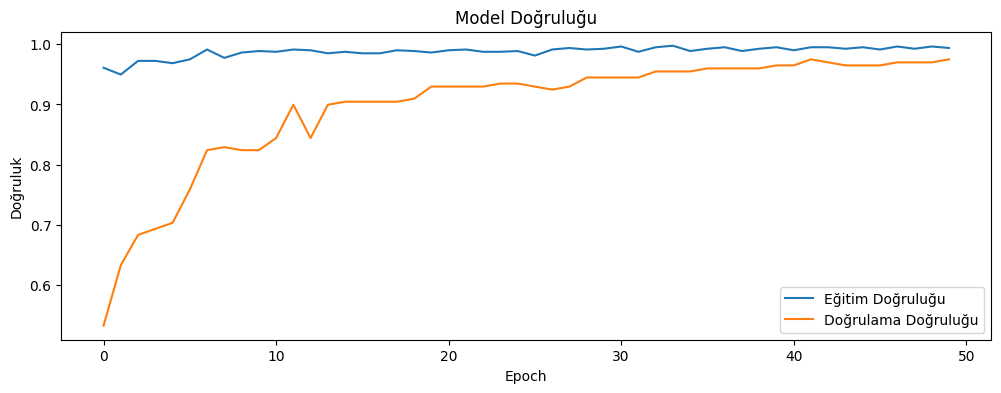

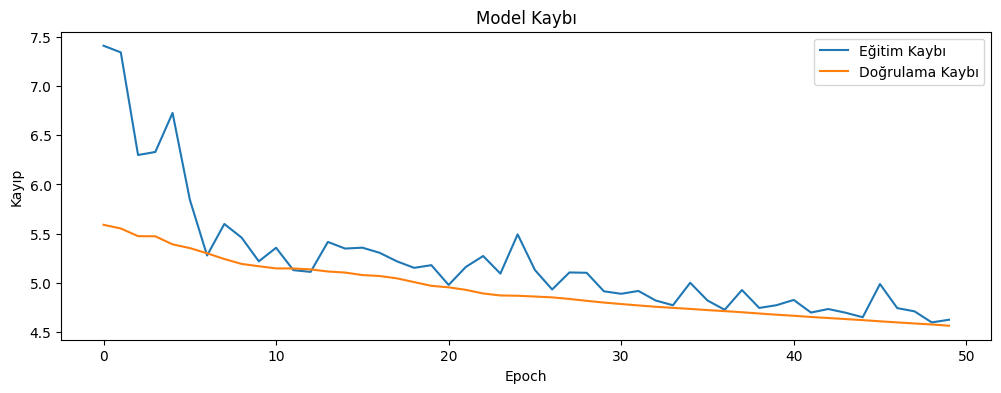

In [ ]:
# Eğitim ve doğrulama doğruluğunu çiz
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını çiz
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()